# Sparse GP Classification (On breast cancer dataset)

・Test LMELBO をプロットしないと意味ない<br>
・<s>MNISTで、バッチサイズ小さめで検証</s>←カーネルの計算が重いと死ぬ<br>
・潜在変数のサンプルは$\mathcal{O}(1)$。各データ点の処理は$\mathcal{O}(M^2)$という致命的な問題がある。<br>
・MLMCは潜在変数のサンプリングコストが支配的なときに使うもの。<br>
・かと言って、潜在変数の空間が複雑だと、カップリングしないという問題もある。

結論…$M$を固定して、Small Dataでなんとか頑張って優位性を示す

## Model Description

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
$f \sim\mathcal{GP}_{\text{FITC}}(K, z_{1:M})$
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
$Y_n \sim \mathrm{Bernoulli}(\sigma(f(x_n)))$,

where $K(x_1,x_2) = \exp\left(\beta - \sum_{d=1,2}\mathrm{softplus}({\alpha_d})\cdot(x_{1d} - x_{2d})^2\right)$.
<br>
Here, latent process $f\sim\mathcal{GP}_{\text{FITC}}(K, z_{1:M})$ is defined as:
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
$u=f_0\small{(z_{1:M})}$ for $f_0\sim\mathcal{GP}(K)$
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
$f(x)\sim\mathcal{GP}(K| f\small{(z_{1:M})}=u)$ <br>
Additionally, conditional independence of process $f$ among any points given $u=f_0\small{(z_{1:M})} = \left(f_0(z_1), ..., f_0(z_M)\right)$ is assumed. <br>
That is, for any $n_1$ and $n_2$, $f(x_{n_1})\perp \!\!\! \perp f(x_{n_1})|u$.

## Local Marginalization of Evidece Lower Bound
By simplifying notation as $f_{1:N} = f(x_{1:N})$ and $u = f(z_{1:M})$, we can write evidence lower bound (ELBO) and locally margianlized likelihood (LM-ELBO).

\begin{align}
\mathrm{LM}\text{-}\mathrm{ELBO}
&= \log p(y_{1:N}) - \mathrm{KL}\left[\ q(u)\ ||\ p(u|y_{1:N})\ \right] \\
&= \mathrm{E}_{u\sim q}\left[\ \log p(y_{1:N}|u)\ \right]
 - \mathrm{KL}\left[\ q(u)\ ||\ p(u)\ \right] \\
&\geq \mathrm{E}_{u\sim q}\left[\ \log p(y_{1:N}|u)
- \mathrm{KL}\left[\ p(f_{1:N}|u)\ ||\ p(f_{1:N}| y_{1:N}, u)\ \right]\ \right]
 - \mathrm{KL}\left[\ q(u)\ ||\ p(u)\ \right] \\
&= \log p(y_{1:N}) - \mathrm{KL}\left[ p(f_{1:N}|u)q(u) || p(y_{1:N}, f_{1:N}, u) \right]\\
&= \mathrm{E}_{u\sim q} \mathrm{E}_{f_{1:N}\sim p(f_{1:N}|u)}\left[
\log \left(\frac{p(y_{1:N}, f_{1:N}, u)}{p(f_{1:N}| u)q(u)}\right) 
\right] \\
&= \sum_{n=1}^N\mathrm{E}_{u\sim q} \mathrm{E}_{f_n\sim p(f_n|u)}
\left[ \log p(y_n| f_n) \right] 
- \mathrm{KL}\left[\ q(u)\ ||\ p(u)\ \right] \\
&= \mathrm{ELBO}
\end{align}

### Possible Datasets
- http://archive.ics.uci.edu/ml/datasets/Adult
- http://archive.ics.uci.edu/ml/datasets/Bar+Crawl%3A+Detecting+Heavy+Drinking
- http://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008
- http://archive.ics.uci.edu/ml/datasets/Buzz+in+social+media+

## Import Packages and Dataset

In [1]:
# Turn GPUs off
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import tensorflow as tf
import numpy as np
np.random.seed(0)

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
import datetime

tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [3]:
import sys
sys.path.append('../')
from src.models.gaussian_process_classification import gaussian_process_classification

## Utilities

In [4]:
def timestamp():
    now = datetime.datetime.now()
    return now.strftime("%Y%m%d%H%M%S")  

## Load Dataset

In [5]:
data = load_breast_cancer()
x = data.data
x = (x - x.mean(axis=0)) / x.std(axis=0) # standardization
y = data.target

In [6]:
x_train = x[:100 ]
x_test  = x[ 100:] 
y_train = y[:100 ]
y_test  = y[ 100:]

## Logistic Regression as a Baseline 

In [7]:
model = LogisticRegression()
model.fit(x_train, y_train)
model.score(x_test, y_test)

0.9488272921108742

In [8]:
p = model.predict_proba(x_test)[:,1]
(y_test*np.log(p) + (1-y_test)*np.log(1-p)).mean()

-0.12784741589549595

In [9]:
idx = np.repeat(np.arange(x_train.shape[0]), 100)
x_repeated = x_train[idx]
y_repeated = y_train[idx]

## Learning Curve by Different Methods

#### 課題：
- ELBOをしっかり最適化すると、汎化損失が減少するが
- LMELBO_MLMC（LM-ELBO）をしっかりと最適化すると、汎化損失が増大する

In [10]:
#import pickle
#with open('../out/gaussian_process_classification/train_log_{}.pickel'.format(timestamp()), 'wb') as file:
#    pickle.dump(results, file)

In [11]:
gpc = gaussian_process_classification(N_total=x_train.shape[0])

In [12]:
gpc.fit(x,y, learning_rate=0.05, n_iter=1001, objective='LMELBO', obj_param={'n_MC':512})
#gpc.fit(x_repeated,y_repeated, learning_rate=0.05, n_iter=401, 
#        objective='LMELBO_MLMC', obj_param={'max_level':9, 'randomize':True})

#iter: 0-49	0.7774426693573995
#iter: 50-99	0.3923152608585268
#iter: 100-149	0.2378273537179625
#iter: 150-199	0.21005523345054047
#iter: 200-249	0.19959727629000618
#iter: 250-299	0.1909838982440838
#iter: 300-349	0.18607746756448595
#iter: 350-399	0.18437312737979106
#iter: 400-449	0.1862423537111682
#iter: 450-499	0.18401715482184894
#iter: 500-549	0.18084220569317297
#iter: 550-599	0.18339313740416976
#iter: 600-649	0.17909141019228147
#iter: 650-699	0.1773142941298427
#iter: 700-749	0.1785352086918472
#iter: 750-799	0.1805285116534068
#iter: 800-849	0.17684501819779228
#iter: 850-899	0.17942746096159695
#iter: 900-949	0.17909824850752387
#iter: 950-999	0.1783206008412549


In [15]:
gpc.fit(x,y, learning_rate=0.01, n_iter=1001, objective='LMELBO', obj_param={'n_MC':512})
#gpc.fit(x_repeated,y_repeated, learning_rate=0.05, n_iter=401, 
#        objective='LMELBO_MLMC', obj_param={'max_level':9, 'randomize':True})

#iter: 0-49	0.1793897782603819
#iter: 50-99	0.17807285281490948
#iter: 100-149	0.17651050611910715
#iter: 150-199	0.1759060805100358
#iter: 200-249	0.17872606393642246
#iter: 250-299	0.18029045231344276
#iter: 300-349	0.17967671060483809
#iter: 350-399	0.17503292875217216
#iter: 400-449	0.17891169955011307
#iter: 450-499	0.18102384047059353
#iter: 500-549	0.1763818485823673
#iter: 550-599	0.18034216724440746
#iter: 600-649	0.1782690056809542
#iter: 650-699	0.17696265269043449
#iter: 700-749	0.1796337338090456
#iter: 750-799	0.18001090047570756
#iter: 800-849	0.1783057335300058
#iter: 850-899	0.18197633608233882
#iter: 900-949	0.17757025198356577
#iter: 950-999	0.17658945815550808


In [13]:
np.mean([gpc.score(x_test,y_test) for i in range(100)])

-0.09062139952483998

In [32]:
gpc = gaussian_process_classification(N_total=x_train.shape[0])

In [33]:
gpc.fit(x,y, learning_rate=0.05, n_iter=301, objective='ELBO')
#gpc.fit(x_repeated,y_repeated, learning_rate=0.05, n_iter=401, objective='LMELBO_MLMC', obj_param={'max_level':4})

#iter: 0-14	1.3144704621786407
#iter: 15-29	0.83773275505743
#iter: 30-44	0.7352441141433167
#iter: 45-59	0.6188544094046904
#iter: 60-74	0.4763739842769416
#iter: 75-89	0.3890212427309236
#iter: 90-104	0.34404989394179747
#iter: 105-119	0.31361822622961466
#iter: 120-134	0.30087365935433946
#iter: 135-149	0.28125125218624547
#iter: 150-164	0.2680034535024312
#iter: 165-179	0.25851046281350876
#iter: 180-194	0.25165937179622655
#iter: 195-209	0.24430068843625358
#iter: 210-224	0.234239793724378
#iter: 225-239	0.22993816924167595
#iter: 240-254	0.22919952495816207
#iter: 255-269	0.22209861527138053
#iter: 270-284	0.22054869524918067
#iter: 285-299	0.2152323309867957


In [34]:
gpc.fit(x_repeated,y_repeated, learning_rate=0.0005, n_iter=1001, 
        objective='LMELBO_MLMC', obj_param={'max_level':9, 'randomize':True})

#iter: 0-49	0.22159988498467928
#iter: 50-99	0.19098867456791557
#iter: 100-149	0.18453317006750264
#iter: 150-199	0.17910813400939887
#iter: 200-249	0.17463111423239908
#iter: 250-299	0.1679577881893531
#iter: 300-349	0.16792863879551018
#iter: 350-399	0.16935553540959056
#iter: 400-449	0.16941923088529642
#iter: 450-499	0.16158822802403214
#iter: 500-549	0.1654800603575531
#iter: 550-599	0.16531486204617377
#iter: 600-649	0.158242762044182
#iter: 650-699	0.16156895767103577
#iter: 700-749	0.15898646701384123
#iter: 750-799	0.16846634968476815
#iter: 800-849	0.16247184050688318
#iter: 850-899	0.16843577355115827
#iter: 900-949	0.15457045480470175
#iter: 950-999	0.16407987426998427


In [37]:
gpc = gaussian_process_classification(N_total=x_train.shape[0])

In [38]:
gpc.fit(x,y, learning_rate=0.05, n_iter=301, objective='ELBO')
#gpc.fit(x_repeated,y_repeated, learning_rate=0.05, n_iter=401, objective='LMELBO_MLMC', obj_param={'max_level':4})

#iter: 0-14	1.3104791387897197
#iter: 15-29	0.8266737604368873
#iter: 30-44	0.7354368161566602
#iter: 45-59	0.6245388548663423
#iter: 60-74	0.4681785427373489
#iter: 75-89	0.3817795594185612
#iter: 90-104	0.34392534215683246
#iter: 105-119	0.3139455270444715
#iter: 120-134	0.3005902053086524
#iter: 135-149	0.2850950911720633
#iter: 150-164	0.2722653550942934
#iter: 165-179	0.2611006084620532
#iter: 180-194	0.2530018490606448
#iter: 195-209	0.2463210486436753
#iter: 210-224	0.23889168008253822
#iter: 225-239	0.23512823580473055
#iter: 240-254	0.2323005729396638
#iter: 255-269	0.22601573163245858
#iter: 270-284	0.22213356379049692
#iter: 285-299	0.22069684029165768


In [39]:
gpc.fit(x,y, learning_rate=0.0005, n_iter=501, objective='ELBO')
#gpc.fit(x_repeated,y_repeated, learning_rate=0.05, n_iter=401, objective='LMELBO_MLMC', obj_param={'max_level':4})

#iter: 0-24	0.2149500194018057
#iter: 25-49	0.21305810387397733
#iter: 50-74	0.20889068141549672
#iter: 75-99	0.20471314286189984
#iter: 100-124	0.20212678681372573
#iter: 125-149	0.1986129679995458
#iter: 150-174	0.20092553799724883
#iter: 175-199	0.19477312216617
#iter: 200-224	0.19801863003592524
#iter: 225-249	0.19834319781098536
#iter: 250-274	0.19640315829494223
#iter: 275-299	0.19556642194923193
#iter: 300-324	0.19337859217831752
#iter: 325-349	0.19474039128480888
#iter: 350-374	0.1944917202365015
#iter: 375-399	0.1923982349362926
#iter: 400-424	0.1937750729953783
#iter: 425-449	0.19173128598362058
#iter: 450-474	0.18902492731389814
#iter: 475-499	0.18689704594747233


In [40]:
gpc.fit(x,y, learning_rate=0.0005, n_iter=501, objective='ELBO')
#gpc.fit(x_repeated,y_repeated, learning_rate=0.05, n_iter=401, objective='LMELBO_MLMC', obj_param={'max_level':4})

#iter: 0-24	0.18986791799157365
#iter: 25-49	0.18608633723287354
#iter: 50-74	0.1870041323059517
#iter: 75-99	0.1869394751323283
#iter: 100-124	0.1854695268164895
#iter: 125-149	0.1898549446516396
#iter: 150-174	0.18758568557676855
#iter: 175-199	0.18853197176233316
#iter: 200-224	0.18751638631275452
#iter: 225-249	0.18831440717411518
#iter: 250-274	0.18938689348216375
#iter: 275-299	0.18693063493795703
#iter: 300-324	0.19243813840886725
#iter: 325-349	0.18636652907596254
#iter: 350-374	0.18706406746626203
#iter: 375-399	0.1906998460550186


KeyboardInterrupt: 

In [41]:
np.mean([gpc.score(x_test,y_test) for i in range(100)])

-0.08840044503884577

In [35]:
np.mean([gpc.score(x_train,y_train) for i in range(100)])

-0.07747380336406895

In [36]:
np.mean([gpc.score(x_train,y_train, objective='LMELBO') for i in range(100)])

-0.1592878969520661

In [14]:
gpc = gaussian_process_classification(N_total=x_train.shape[0])

In [29]:
gpc = gaussian_process_classification(N_total=x_train.shape[0])
gpc.fit(x,y, learning_rate=0.05, n_iter=1001, objective='ELBO')

#iter: 0-49	0.9342641728176148
#iter: 50-99	0.46532189584987593
#iter: 100-149	0.31063656661970973
#iter: 150-199	0.2670957027238154
#iter: 200-249	0.24750117583650266
#iter: 250-299	0.23399270567686098
#iter: 300-349	0.22548548815528682
#iter: 350-399	0.22184628865883094
#iter: 400-449	0.2172127511693861
#iter: 450-499	0.21476450198020416
#iter: 500-549	0.20839701785724343
#iter: 550-599	0.2082822345876159
#iter: 600-649	0.20727459473082546
#iter: 650-699	0.20509538316792203
#iter: 700-749	0.205772993267811
#iter: 750-799	0.20401481942714178
#iter: 800-849	0.20027403749352754
#iter: 850-899	0.20053268169774563
#iter: 900-949	0.1980867681299836
#iter: 950-999	0.20042124784389903


In [16]:
np.mean([gpc.score(x_test,y_test) for i in range(100)])

-0.09639040262145925

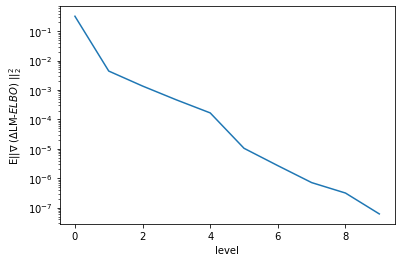

In [28]:
gpc.plot_convergence(x_repeated, y_repeated, max_level=10)